In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

import copy
import random

from ECGDataset import ECGDataset

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
window_size = 180

train_ds= ECGDataset(f"data/generated/normal_train_180_dpmerf.csv", f"data/train_labels_{window_size}.csv")
test_normal_ds = ECGDataset(f"data/normal_test{window_size}.csv", f"data/normal_labels_{window_size}.csv")
test_anomalie_ds = ECGDataset(f"data/anomalie_test{window_size}.csv", f"data/anomalie_labels_{window_size}.csv")
val_ds = ECGDataset(f"data/normal_val_{window_size}.csv", f"data/val_labels_{window_size}.csv")


In [4]:
train_ds.y

[['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],


['N']

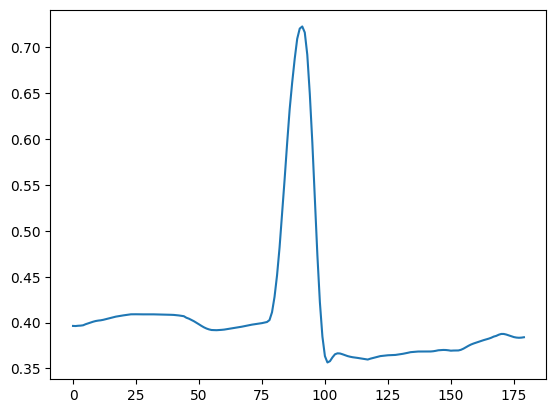

In [5]:
plt.plot(train_ds.df[1])
train_ds.y[0]

In [9]:
def train_model(model, train_dataset, val_dataset, n_epochs, lr, batch_size):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    val_losses = []

    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset)

    size = len(train_dl.dataset)
    for batch, (X,y) in enumerate(train_dl):
        # Compute prediction and loss
        X = X.to(device)
        pred = model(X)
        loss = criterion(pred, X)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    with torch.no_grad():  # requesting pytorch to record any gradient for this block of code
      for (seq_true, y) in val_dl:
        seq_true = seq_true.to(device)   # putting sequence to gpu
        seq_pred = model(seq_true).unsqueeze(0)    # prediction

        loss = criterion(seq_pred, seq_true)  # recording loss

        val_losses.append(loss.item())    # storing loss into the validation losses

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train loss = {train_loss}, val loss = {val_loss}')

  return model.eval(), history

In [10]:
from lstmae import RecurrentAutoencoder

model = RecurrentAutoencoder(180, 1, device, 32)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [11]:
model, history = train_model(
  model, 
  train_dataset=train_ds, 
  val_dataset=val_ds,
  n_epochs=10,
  lr=3e-4,
  batch_size=1
)

loss: 84.930191  [    1/71243]
loss: 12.429394  [10001/71243]
loss: 3.353643  [20001/71243]
loss: 1.781557  [30001/71243]
loss: 1.936815  [40001/71243]
loss: 30.820391  [50001/71243]
loss: 1.434682  [60001/71243]
loss: 1.084210  [70001/71243]
Epoch 1: train loss = 4.1276127562095635, val loss = 4.4780882634608306
loss: 7.319215  [    1/71243]
loss: 9.405989  [10001/71243]
loss: 8.627016  [20001/71243]
loss: 5.724554  [30001/71243]
loss: 2.614890  [40001/71243]
loss: 2.246291  [50001/71243]
loss: 0.745448  [60001/71243]
loss: 0.287468  [70001/71243]
Epoch 2: train loss = 2.724791549115952, val loss = 4.0652082836456325
loss: 0.857699  [    1/71243]
loss: 1.367972  [10001/71243]
loss: 0.998433  [20001/71243]
loss: 0.968324  [30001/71243]
loss: 0.948474  [40001/71243]
loss: 1.282269  [50001/71243]
loss: 1.134240  [60001/71243]
loss: 1.144656  [70001/71243]
Epoch 3: train loss = 2.3250091095194287, val loss = 3.540652108330954
loss: 0.242868  [    1/71243]
loss: 1.225543  [10001/71243]
los

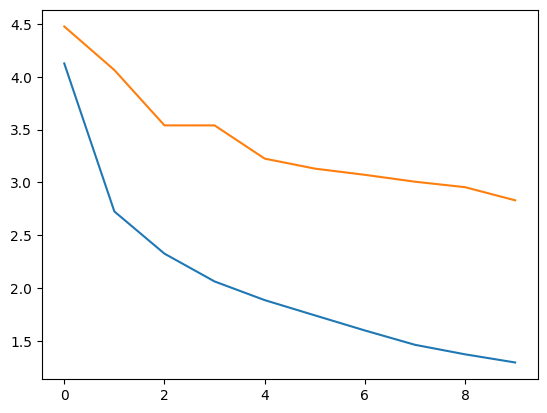

In [12]:
plt.plot(history["train"])
plt.plot(history["val"])

In [13]:
torch.save(model.state_dict(), "models/lstmae_180_embed32_dpmerf_gen.pth")

In [12]:
model.load_state_dict(torch.load("models/lstmae_5000.pth", map_location=torch.device('cpu')))
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [14]:
model = model.to(device="cpu")

In [15]:
train_ds.__getitem__(0)

(tensor([[0.4419],
         [0.4417],
         [0.4421],
         [0.4421],
         [0.4429],
         [0.4439],
         [0.4449],
         [0.4461],
         [0.4472],
         [0.4482],
         [0.4491],
         [0.4490],
         [0.4492],
         [0.4493],
         [0.4495],
         [0.4496],
         [0.4501],
         [0.4505],
         [0.4508],
         [0.4511],
         [0.4514],
         [0.4518],
         [0.4528],
         [0.4535],
         [0.4542],
         [0.4548],
         [0.4555],
         [0.4563],
         [0.4581],
         [0.4596],
         [0.4614],
         [0.4630],
         [0.4647],
         [0.4656],
         [0.4667],
         [0.4678],
         [0.4687],
         [0.4693],
         [0.4697],
         [0.4698],
         [0.4698],
         [0.4696],
         [0.4691],
         [0.4685],
         [0.4681],
         [0.4685],
         [0.4691],
         [0.4699],
         [0.4709],
         [0.4719],
         [0.4701],
         [0.4693],
         [0.

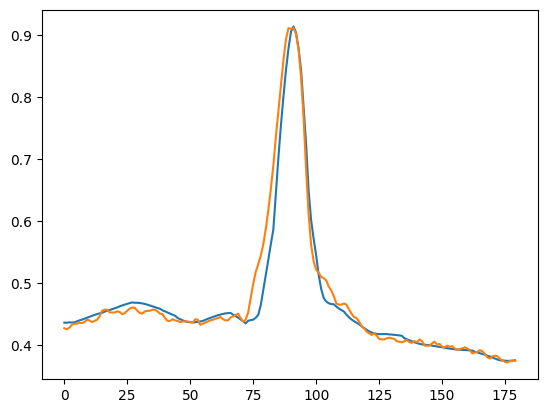

In [16]:
plt.plot(model(test_normal_ds.__getitem__(12)[0]).cpu().detach().numpy().squeeze())
plt.plot(test_normal_ds.__getitem__(12)[0].cpu().detach().numpy().squeeze())

In [17]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true, y in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

In [18]:
model = model.to(device)

In [19]:
_, losses_test_normal = predict(model, test_normal_ds)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


(array([ 65., 314., 669., 809., 859., 933., 852., 758., 586., 547., 413.,
        369., 321., 240., 187., 150., 105.,  99.,  83.,  87.,  79.,  55.,
         41.,  34.,  25.,  23.,  14.,   8.,   4.,   2.,   6.,   3.,   3.,
          2.,   1.,   0.,   2.,   3.,   0.,   3.,   1.,   2.,   1.,   0.,
          0.,   1.,   0.,   1.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   1.,   3.,   2.,   0.,   0.,   0.,   0.,   3.,   1.,
          1.,   1.,   2.,   3.,   3.,   4.,   1.,   1.,   1.,   1.,   3.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([ 0.89431477,  1.12810197,  1.36188917,  1.59567637,  1.82946358,
         2.06325078,  2.29703798,  2.53082519,  2.76461239,  2.99839959,
         3.23218679,  3.465974  ,  3.6997612 ,  3.9335484 ,  4.16733561,
         4.40112281,  4.63491001,  4.86869721,  5.10248442,  5.33627162,
         5.57005882,  5.80

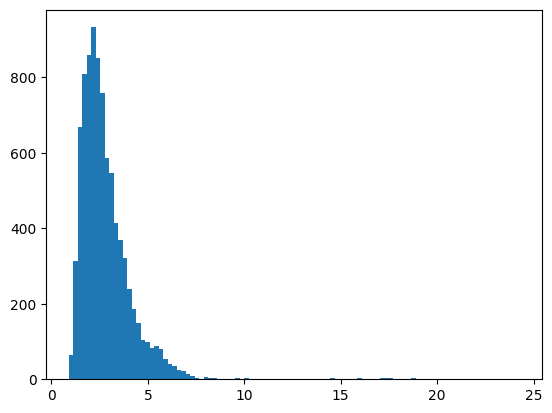

In [20]:
plt.hist(losses_test_normal, bins=100)

In [21]:
THRESHOLD = 2.5

In [22]:
correct = sum(l <= THRESHOLD for l in losses_test_normal)
print(f'Correct normal predictions: {correct}/{len(test_normal_ds)} or  {correct/len(test_normal_ds)}')

Correct normal predictions: 4402/8797 or  0.5003978629078095


In [23]:
_, losses_test_anomaly = predict(model, test_anomalie_ds)

(array([9.750e+02, 3.000e+03, 2.410e+03, 2.155e+03, 2.669e+03, 2.117e+03,
        1.516e+03, 1.523e+03, 1.331e+03, 7.870e+02, 4.860e+02, 2.440e+02,
        1.540e+02, 1.780e+02, 2.560e+02, 2.370e+02, 2.380e+02, 2.290e+02,
        1.650e+02, 1.440e+02, 1.660e+02, 1.320e+02, 8.600e+01, 2.900e+01,
        1.200e+01, 9.000e+00, 7.000e+00, 1.400e+01, 7.000e+00, 9.000e+00,
        1.200e+01, 7.000e+00, 9.000e+00, 2.000e+00, 6.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.83013827,  1.95685871,  3.08357916,  4.21029961,  5.33702005,
         6.4637405 ,  7.59046094,  8.71718139,  9.84390184, 10.97062228,
        12.09734273, 13.22406318, 14.35078362, 15.47750407, 16.60422451,
        17.73094496, 18.85766541, 19.98438585, 21.1111063 , 22.23782675,
        23.36454719, 24.49126764, 25.61798809, 26.74470853, 27.87142898,
        28.

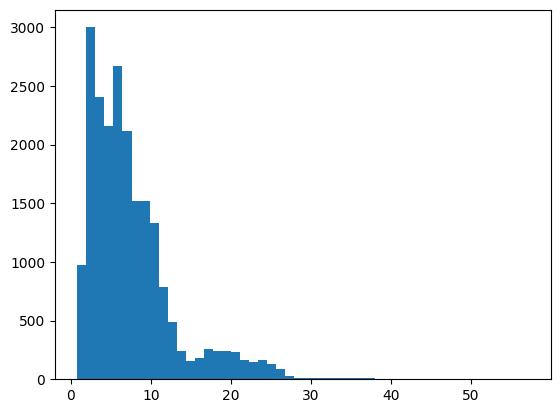

In [24]:
plt.hist(losses_test_anomaly, bins=50)

In [25]:
correct = sum(l > THRESHOLD for l in losses_test_anomaly)
print(f'Correct anomaly predictions: {correct}/{len(test_anomalie_ds)} or  {correct/len(test_anomalie_ds)}')

Correct anomaly predictions: 18870/21326 or  0.8848354121729345


In [26]:
def find_threshold(loss_normal, loss_anomaly):
    threshold_list = np.linspace(0,5,21)
    corr_normal = []
    corr_anomaly = []
    for th in threshold_list:
        corr_normal.append(sum(l <= th for l in loss_normal)/len(loss_normal))
        corr_anomaly.append(sum(l > th for l in loss_anomaly)/len(loss_anomaly))
    return corr_normal, corr_anomaly

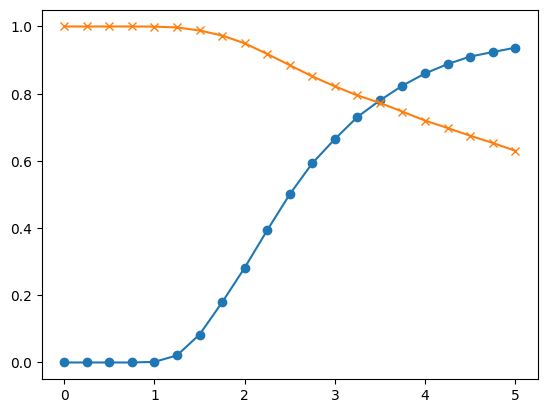

In [27]:
p1, p2= find_threshold(losses_test_normal, losses_test_anomaly)
plt.plot(np.linspace(0,5,21), p1, marker="o")
plt.plot(np.linspace(0,5,21), p2, marker="x")

In [28]:
def predict_classes(model, dataset, threshold=3.5):
    predictions, losses = [], []
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true, y in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)
            pred = "N" if loss <= threshold else "A"
            predictions.append(pred)
            losses.append(loss.item())
    return predictions

In [29]:
from sklearn import metrics
    
pred_normal = predict_classes(model, test_normal_ds, threshold=3.5)
pred_anomaly = predict_classes(model, test_anomalie_ds, threshold=3.5)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [30]:
print(f"Acc: {metrics.accuracy_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly)}")
print(f"Precision: {metrics.precision_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly, pos_label='N')}")
print(f"Recall: {metrics.recall_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly, pos_label='N')}")
print(f"F1: {metrics.f1_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly, pos_label='N')}")

Acc: 0.7748896192278325
Precision: 0.586094977792962
Recall: 0.7800386495396158
F1: 0.6693001706900755
